In [34]:
!pip install --upgrade pip
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import scipy.stats as stats
import warnings
warnings.filterwarnings(action='ignore')


In [36]:
df = pd.read_csv('Electric Vehicle Population Data.csv')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,2T3YL4DV0E,King,Bellevue,WA,98005.0,2014,TOYOTA,RAV4,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,103.0,0.0,41.0,186450183,POINT (-122.1621 47.64441),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
1,5YJ3E1EB6K,King,Bothell,WA,98011.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,1.0,478093654,POINT (-122.20563 47.76144),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
2,5UX43EU02S,Thurston,Olympia,WA,98502.0,2025,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,40.0,0.0,35.0,274800718,POINT (-122.92333 47.03779),PUGET SOUND ENERGY INC,5.306701e+10
3,JTMAB3FV5R,Thurston,Olympia,WA,98513.0,2024,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,2.0,260758165,POINT (-122.81754 46.98876),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJYGDEE8M,Yakima,Selah,WA,98942.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,236581355,POINT (-120.53145 46.65405),PACIFICORP,5.307700e+10


In [38]:
df.shape

(232230, 17)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232230 entries, 0 to 232229
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         232230 non-null  object 
 1   County                                             232226 non-null  object 
 2   City                                               232226 non-null  object 
 3   State                                              232230 non-null  object 
 4   Postal Code                                        232226 non-null  float64
 5   Model Year                                         232230 non-null  int64  
 6   Make                                               232230 non-null  object 
 7   Model                                              232230 non-null  object 
 8   Electric Vehicle Type                              232230 non-null  object

In [42]:
# Check for duplicated Values
df.duplicated().sum()

0

In [44]:
# Check for missing values
df.isnull().sum()

VIN (1-10)                                             0
County                                                 4
City                                                   4
State                                                  0
Postal Code                                            4
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                        27
Base MSRP                                             27
Legislative District                                 481
DOL Vehicle ID                                         0
Vehicle Location                                      11
Electric Utility                                       4
2020 Census Tract                                      4
dtype: int64

In [48]:
# Cleaning the data 
df_clean=df.copy()
#Handle missing values
df['County'].fillna('Unknown',inplace=True)
df['City'].fillna('Unknown',inplace=True)
df['State'].fillna('Unknown',inplace=True)
df['Postal Code'].fillna(df['Postal Code'].median(),inplace=True)
df['Electric Range'].fillna(df['Electric Range'].median(),inplace=True) 
df['Base MSRP'].fillna(df['Base MSRP'].median(),inplace=True)
df['Legislative District'].fillna(df['Legislative District'].median(),inplace=True)
df['Vehicle Location'].fillna('Unknown',inplace=True)
df['Electric Utility'].fillna('Unknown',inplace=True)
df['2020 Census Tract'].fillna(df['2020 Census Tract'].median(),inplace=True)


In [50]:
#Check if there are any missing values after cleaning
print('Remaining missing values after cleaning:')
df_clean.isnull().sum()


Remaining missing values after cleaning:


VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

In [52]:
# Display statistical features of the numerical columns
df_clean.describe()

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,232230.000000,232230.000000,232230.000000,232230.000000,232230.000000,2.322300e+05,2.322300e+05
mean,98180.171111,2021.353727,46.750562,803.715519,28.887439,2.343671e+08,5.298177e+10
std,2489.386514,2.994884,84.370197,7246.181011,14.889735,6.831418e+07,1.507801e+09
min,1731.000000,1999.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2020.000000,0.000000,0.000000,17.000000,2.034737e+08,5.303301e+10
50%,98126.000000,2023.000000,0.000000,0.000000,32.000000,2.512717e+08,5.303303e+10
75%,98375.000000,2023.000000,38.000000,0.000000,42.000000,2.686943e+08,5.305307e+10
max,99577.000000,2025.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.602100e+10


In [55]:
# check values for categorical columns
categorical_columns = df_clean.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df[col].nunique()
    if unique_values <= 10: # Display the number if it is less than or equal to 10
      print(f'\n{col} -{unique_values} unique values :')
      print(df[col].value_counts().head())
    else:
      print(f'\n{col} -{unique_values} unique values too many to display')


VIN (1-10) -13560 unique values too many to display

County -210 unique values too many to display

City -787 unique values too many to display

State -49 unique values too many to display

Make -46 unique values too many to display

Model -170 unique values too many to display

Electric Vehicle Type -2 unique values :
Electric Vehicle Type
Battery Electric Vehicle (BEV)            184054
Plug-in Hybrid Electric Vehicle (PHEV)     48176
Name: count, dtype: int64

Clean Alternative Fuel Vehicle (CAFV) Eligibility -3 unique values :
Clean Alternative Fuel Vehicle (CAFV) Eligibility
Eligibility unknown as battery range has not been researched    136865
Clean Alternative Fuel Vehicle Eligible                          72847
Not eligible due to low battery range                            22518
Name: count, dtype: int64

Vehicle Location -949 unique values too many to display

Electric Utility -77 unique values too many to display


In [57]:
#Create a numerical columns list for all numeircal type columns for the dataset
numerical_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
#Display statistical features of the numerical columns
print(f'Numerical Values Columns:')
display(df_clean[numerical_columns].describe())

Numerical Values Columns:


,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,232230.000000,232230.000000,232230.000000,232230.000000,232230.000000,2.322300e+05,2.322300e+05
mean,98180.171111,2021.353727,46.750562,803.715519,28.887439,2.343671e+08,5.298177e+10
std,2489.386514,2.994884,84.370197,7246.181011,14.889735,6.831418e+07,1.507801e+09
min,1731.000000,1999.000000,0.000000,0.000000,1.000000,4.385000e+03,1.001020e+09
25%,98052.000000,2020.000000,0.000000,0.000000,17.000000,2.034737e+08,5.303301e+10
50%,98126.000000,2023.000000,0.000000,0.000000,32.000000,2.512717e+08,5.303303e+10
75%,98375.000000,2023.000000,38.000000,0.000000,42.000000,2.686943e+08,5.305307e+10
max,99577.000000,2025.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.602100e+10


In [61]:
# drop unwanted numerical values and pick only the imprortant ones
Imp_Numerical_Columns=['Model Year','Electric Range','Base MSRP','Legislative District']

In [63]:
# creat new dataframe for important numerical columns
df_ImportantNumeric=df_clean[Imp_Numerical_Columns]
df_ImportantNumeric

,Model Year,Electric Range,Base MSRP,Legislative District
0,2014,103.0,0.0,41.0
1,2019,220.0,0.0,1.0
2,2025,40.0,0.0,35.0
3,2024,42.0,0.0,2.0
4,2021,0.0,0.0,15.0
...,...,...,...,...
232225,2019,220.0,0.0,47.0
232226,2024,0.0,0.0,39.0
232227,2024,0.0,0.0,45.0
232228,2023,42.0,0.0,12.0


,Model Year,Electric Range,Base MSRP,Legislative District
Model Year,1.000000,-0.527689,-0.228721,-0.013830
Electric Range,-0.527689,1.000000,0.116431,0.015915
Base MSRP,-0.228721,0.116431,1.000000,0.010566
Legislative District,-0.013830,0.015915,0.010566,1.000000


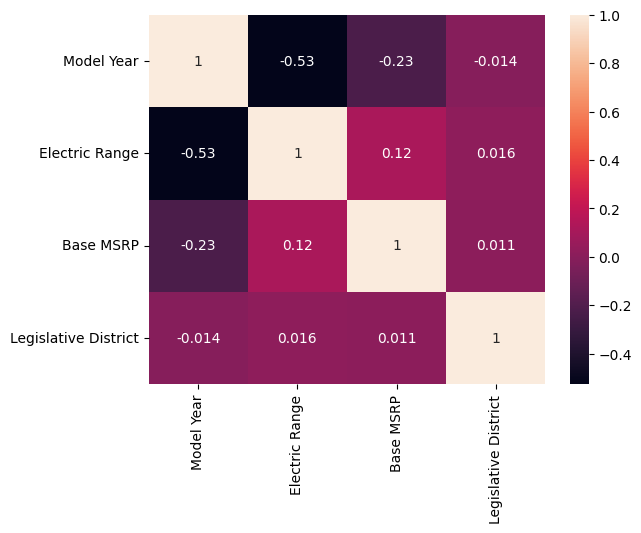

In [65]:
# Correlation Matrix for Important Numerical Columns
correlation_matrix = df_ImportantNumeric.corr()
display(correlation_matrix) # display correlation matrix 

# Heatmap for Correlation Matrix
sns.heatmap(correlation_matrix, annot=True)
plt.show()

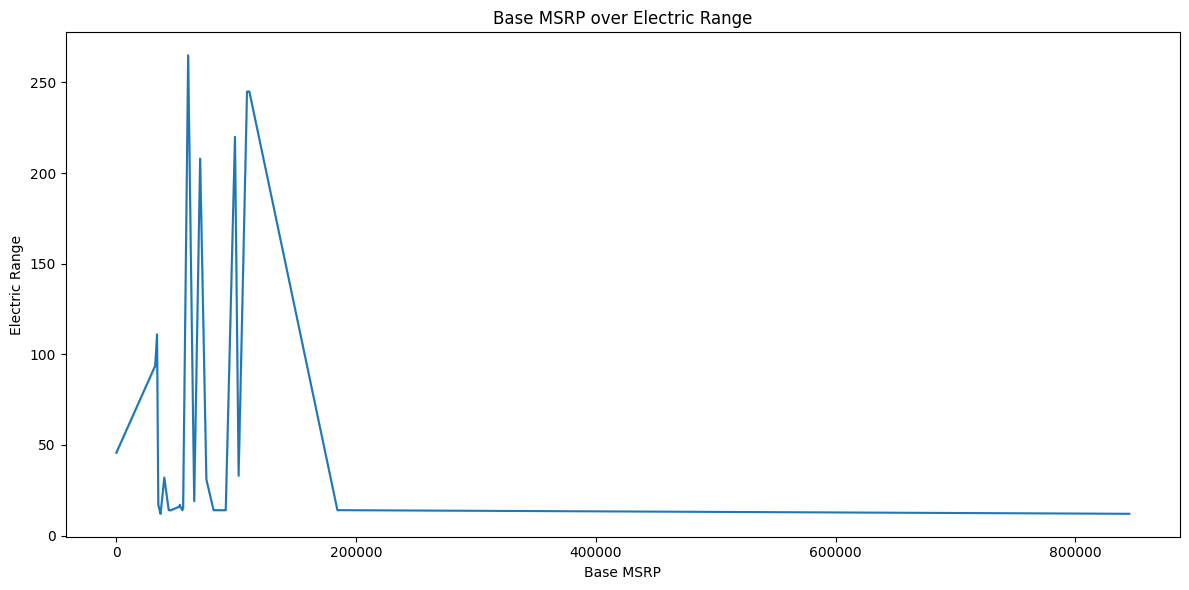

In [76]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Base MSRP', y='Electric Range', data=df_ImportantNumeric)
plt.xticks()
plt.title(f'Base MSRP over Electric Range')
plt.tight_layout()
plt.show()

Electric Range Correlations:
Electric Range          1.000000
Base MSRP               0.116431
Legislative District    0.015915
Model Year             -0.527689
Name: Electric Range, dtype: float64


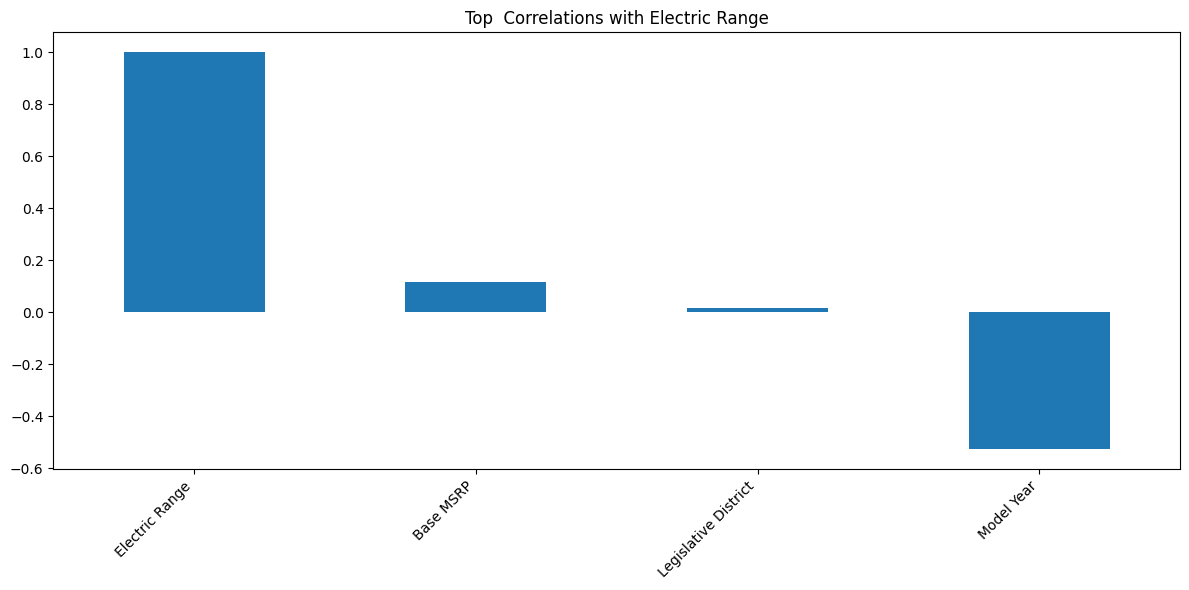

In [67]:
# Calculate correlations with Electric Range
correlations = df_ImportantNumeric.corr()['Electric Range'].sort_values(ascending=False)
print("Electric Range Correlations:")
print(correlations)

# Create a visualization of top 10 correlations
plt.figure(figsize=(12, 6))
correlations[0:5].plot(kind='bar')
plt.title('Top  Correlations with Electric Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [69]:
# Test relationship between Electric Range and Model Year
from scipy import stats
import numpy as np
slope, intercept, r_value, p_value, std_err = stats.linregress(df_ImportantNumeric['Electric Range'], df_ImportantNumeric['Model Year'])

print("Linear Regression Results for Electric Range vs Model Year:")
print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Standard Error: {std_err:.4f}")

Linear Regression Results for Electric Range vs Model Year:
Slope: -0.0187
P-value: 0.0000000000
R-squared: 0.2785
Standard Error: 0.0001


In [17]:
# Save df_clean to csv file for further data visulaization and analysis in Tableau
df_clean.to_csv('Electric_Vehicle.csv', index=False)

In [18]:
import os
print(os.path.expanduser("~/Desktop"))


/root/Desktop


In [28]:
df_clean.to_csv(r"C:\Users\Sonal\Downloads\Electric_Vehicle.csv", index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1096132-6631-4bf6-b18c-76700fda94f6' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>